In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d yasserhessein/gender-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/gender-dataset
License(s): unknown
 99% 1.30G/1.32G [00:09<00:00, 151MB/s]
100% 1.32G/1.32G [00:09<00:00, 153MB/s]


In [ ]:
! unzip gender-dataset.zip

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
train_path = '/content/Dataset/Train'
validation_path = '/content/Dataset/Validation'
test_path = '/content/Dataset/Test'

image_size = 224
batch_size = 256

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_size , image_size),
    batch_size=batch_size,
    shuffle=True,
    labels='inferred'
)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    image_size = (image_size , image_size),
    shuffle=True,
    labels='inferred'
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(image_size,image_size),
    shuffle=True,
    labels='inferred'
    )

Found 160000 files belonging to 2 classes.
Found 22598 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.


In [ ]:
labels_list = train_dataset.class_names

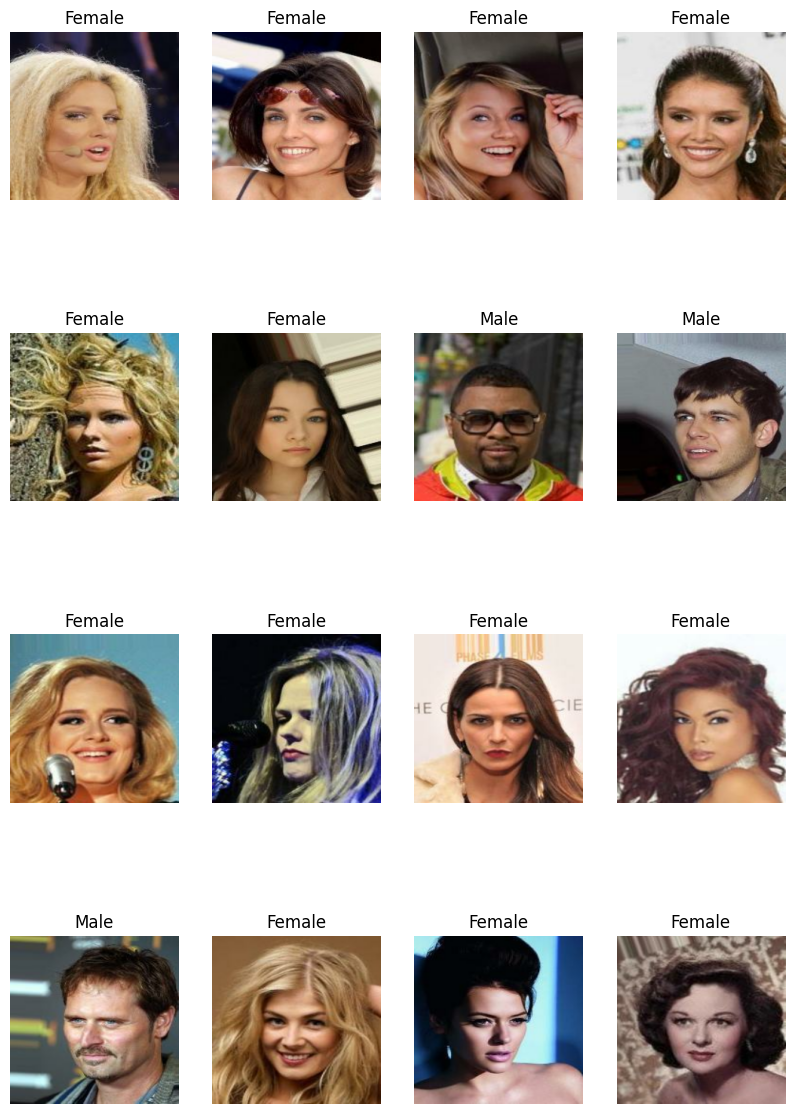

In [ ]:
plt.figure(figsize=(10,15))
for i , (image , label) in enumerate(train_dataset.take(16)):
  plt.subplot(4 , 4 , i+1)
  plt.imshow(image[i].numpy().astype('uint8'))
  plt.title(labels_list[label[i].numpy()])
  plt.axis('off')

In [ ]:
augment_data = tf.keras.models.Sequential([
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomBrightness(0.1),
])

In [ ]:
def preprocess_and_augmentation_for_train(image , label):
  image = augment_data(image)
  image = tf.cast(image , tf.float32) / 255.0
  return image , label

def preprocess_and_augmentation_for_test(image , label):
  image = tf.cast(image , tf.float32) / 255.0
  return image , label

In [ ]:
train_dataset = train_dataset.map(preprocess_and_augmentation_for_train , num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_and_augmentation_for_test , num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_and_augmentation_for_test)

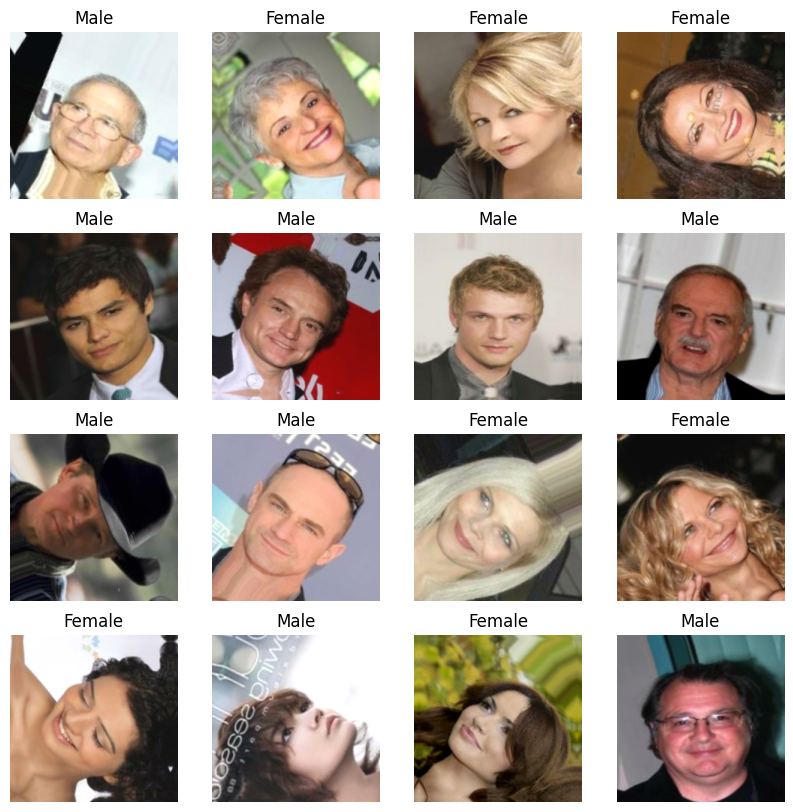

In [ ]:
plt.figure(figsize=(10,10))
for i , (image , label) in enumerate(train_dataset.take(16)):
  plt.subplot(4 , 4 , i+1)
  plt.imshow(image[i].numpy())
  plt.title(labels_list[label[i]])
  plt.axis('off')

In [ ]:
labels_list

['Female', 'Male']

In [ ]:
total_sample = 0
class_counter = {}
for image , label in train_dataset:
  total_sample += tf.shape(label)[0]
  for i in label:
    if i.numpy() in class_counter:
      class_counter[i.numpy()] += 1
    else:
      class_counter[i.numpy()] = 1

max_val = max(class_counter.values())
class_weights = {label: max_val/count for label, count in class_counter.items()}

In [ ]:
class_weights

{1: 1.3825478370932915, 0: 1.0}

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
n_channels = 3
epochs = 10
checkpoint = tf.keras.callbacks.ModelCheckpoint('gender_classification.h5' , monitor='val_accuracy' , save_best_only=True , save_weights_only=False, mode='max' , save_freq='epoch')
with strategy.scope():
  base_model = tf.keras.applications.MobileNet(weights='imagenet' , include_top=False , input_shape=(image_size,image_size,n_channels))
  input = base_model.input
  x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  output = tf.keras.layers.Dense(1 , activation='sigmoid')(x)

  model = tf.keras.Model(inputs=input , outputs=output)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4) , loss='binary_crossentropy' , metrics=['accuracy'])

  history = model.fit(train_dataset , validation_data=validation_dataset , epochs=epochs , callbacks=[checkpoint] , class_weight=class_weights)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.7839

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 174s 176ms/step - loss: 0.5291 - accuracy: 0.7839 - val_loss: 0.2690 - val_accuracy: 0.9523
Epoch 2/10
625/625 [==============================] - 140s 218ms/step - loss: 0.3195 - accuracy: 0.9164 - val_loss: 0.1376 - val_accuracy: 0.9759
Epoch 3/10
625/625 [==============================] - 158s 246ms/step - loss: 0.2306 - accuracy: 0.9481 - val_loss: 0.0846 - val_accuracy: 0.9799
Epoch 4/10
625/625 [==============================] - 144s 225ms/step - loss: 0.1798 - accuracy: 0.9613 - val_loss: 0.0739 - val_accuracy: 0.9777
Epoch 5/10
625/625 [==============================] - 151s 236ms/step - loss: 0.1488 - accuracy: 0.9680 - val_loss: 0.0602 - val_accuracy: 0.9824
Epoch 6/10
625/625 [==============================] - 138s 215ms/step - loss: 0.1249 - accuracy: 0.9729 - val_loss: 0.0953 - val_accuracy: 0.9648
Epoch 7/10
625/625 [==============================] - 149s 233ms/step - loss: 0.1123 - accuracy: 0.9750 - val_loss: 0.1194 - val_accura

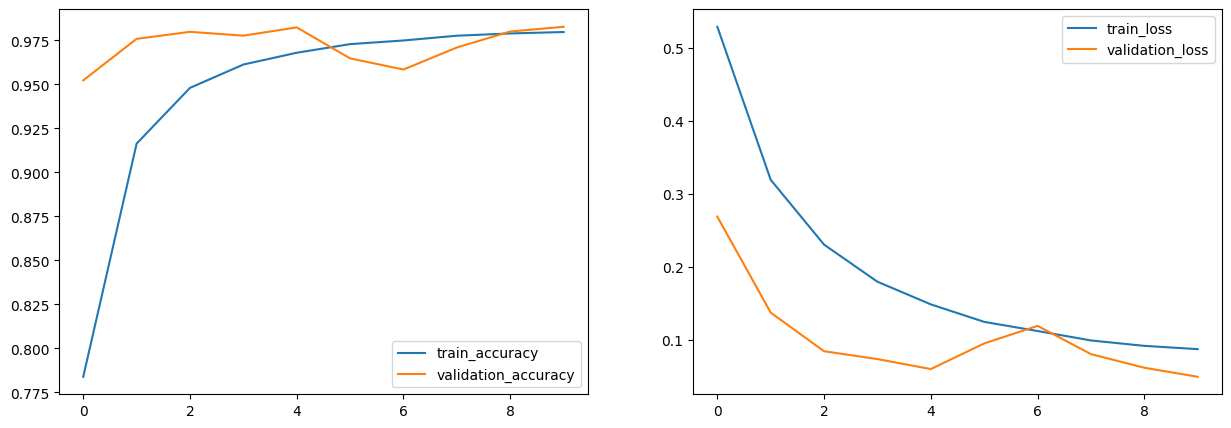

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1 , 2 , 1);plt.plot(history.history['accuracy'] , label='train_accuracy');plt.plot(history.history['val_accuracy'] , label='validation_accuracy');plt.legend();
plt.subplot(1 , 2 , 2);plt.plot(history.history['loss'] , label='train_loss');plt.plot(history.history['val_loss'] , label='validation_loss');plt.legend();

In [ ]:
model.evaluate(test_dataset)

626/626 [==============================] - 12s 18ms/step - loss: 0.0415 - accuracy: 0.9859


[0.04152470454573631, 0.9859007000923157]

In [ ]:
loaded_model = tf.keras.models.load_model('gender_classification.h5')

In [ ]:
loaded_model.evaluate(test_dataset)

626/626 [==============================] - 104s 165ms/step - loss: 0.0414 - accuracy: 0.9862


[0.041369419544935226, 0.9862006902694702]

In [ ]:
predicted = loaded_model.predict(test_dataset)

626/626 [==============================] - 114s 181ms/step


In [ ]:
def F_or_M(x):
  return 'female' if x < 0.5 else 'male'

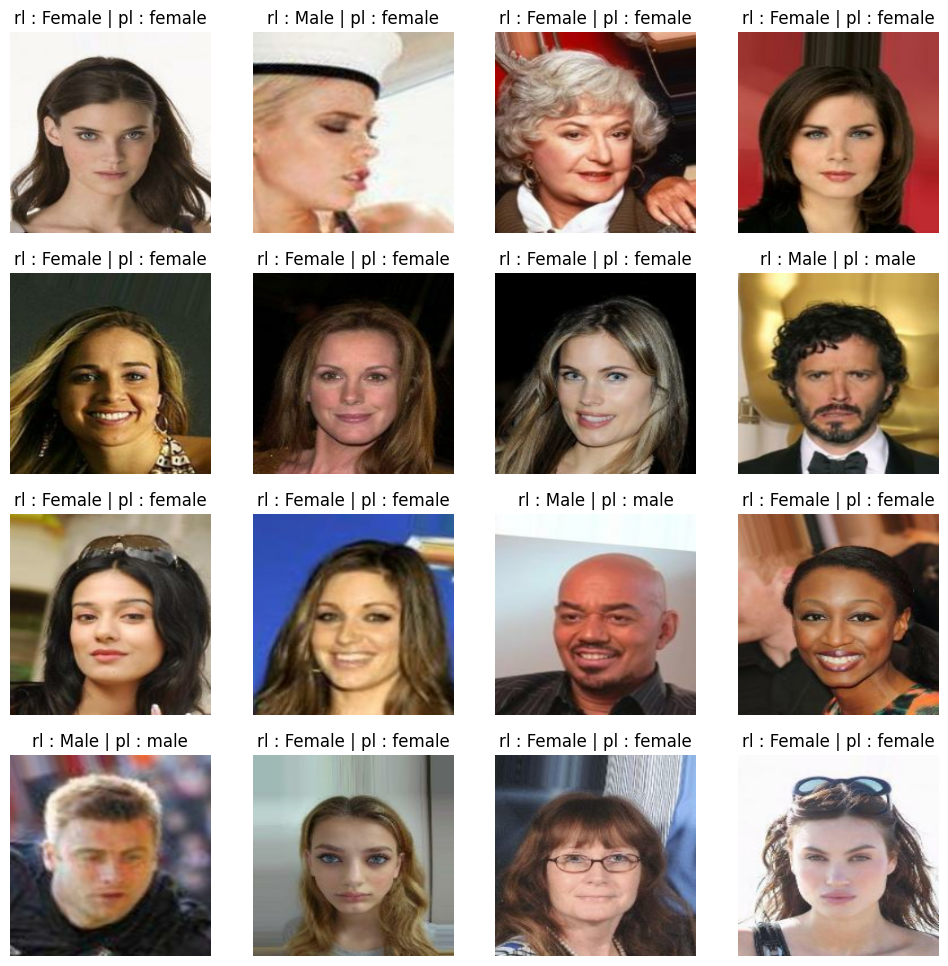

In [ ]:
plt.figure(figsize=(12,12))
for i , (image,label) in enumerate(test_dataset.take(16)):
  plt.subplot(4 , 4 , i+1)
  plt.imshow(image[i])
  plt.axis('off')
  predicted_label = loaded_model.predict(tf.expand_dims(image[i] , axis = 0) , verbose=0)
  plt.title('rl : {} | pl : {}'.format(labels_list[label[i]],F_or_M(predicted_label[0])))